In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt

from plotting import *
from data_processing import *

np.set_printoptions(precision=2, suppress=False)


# Sociohydrodynamics model


$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j  - \Gamma_i \phi_i \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

## Load data

(256, 232) (100, 110)
[1014.78 1015.01 1015.25 1015.49 1015.73]
[578.51 578.7  578.9  579.09 579.29]
(256, 232) 0


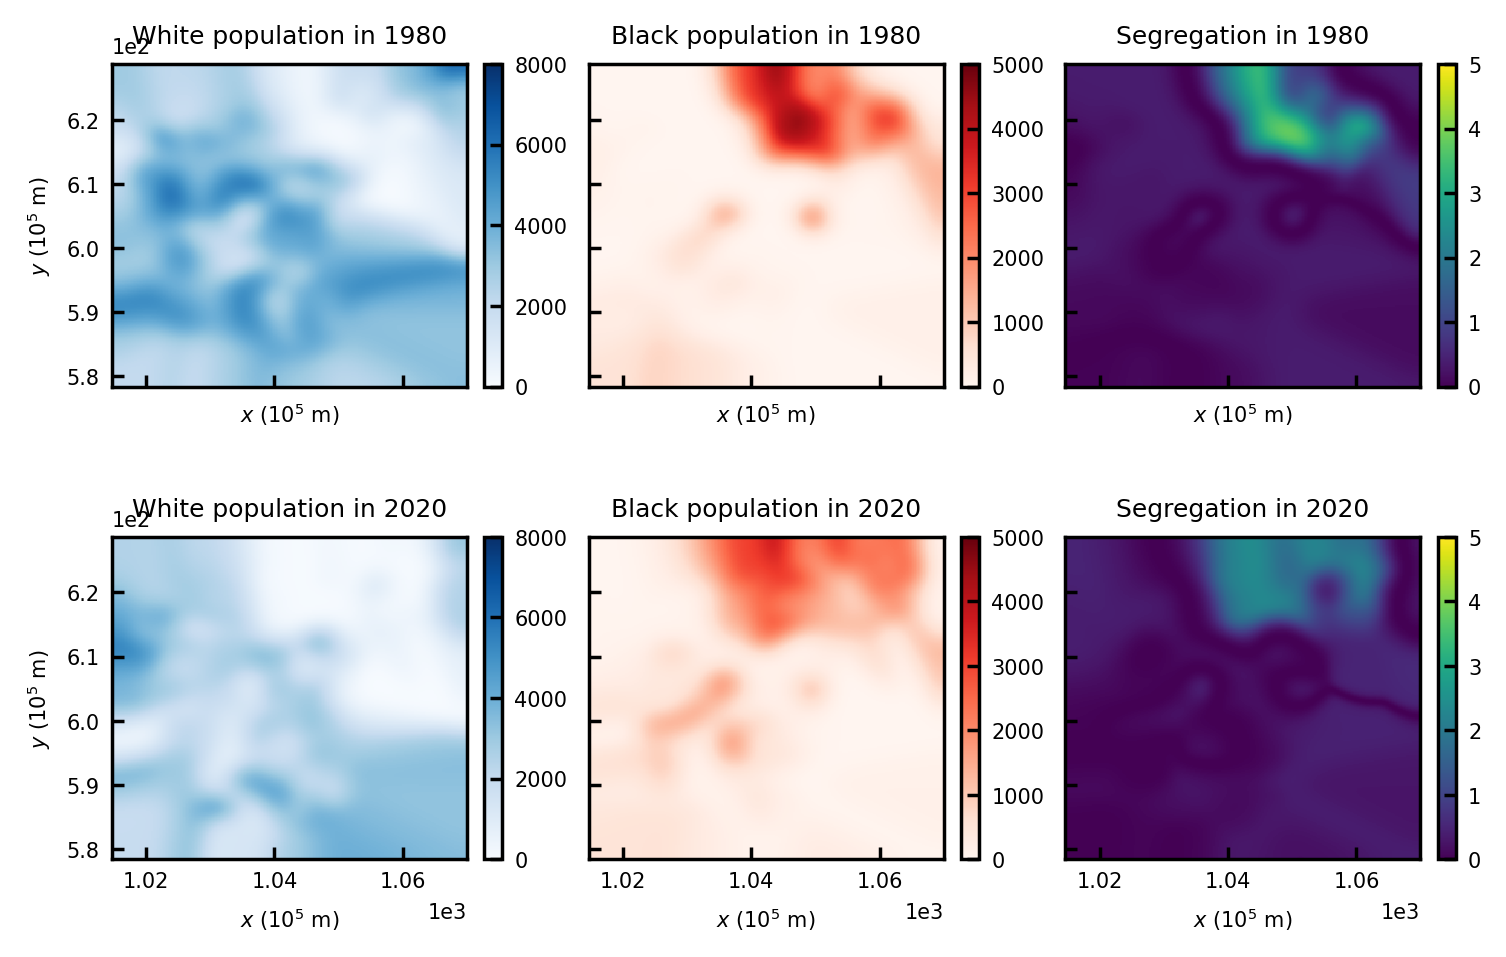

In [19]:
from scipy.interpolate import griddata

'''
Load and plot data from HDF5 files 
'''
with h5py.File("data/wayne_MI.hdf5", "r") as d:
    x_grid = d["x_grid"][:] / 1e3
    y_grid = d["y_grid"][:] / 1e3
    w_grid = d["w_grid_array_masked"][:].transpose(2, 0, 1)
    b_grid = d["b_grid_array_masked"][:].transpose(2, 0, 1)
    
    Ny = 256
    Nx = int(N * x_grid.shape[0] / x_grid.shape[1])
    
    X_grid, Y_grid = np.meshgrid(
        np.linspace(x_grid.min(), x_grid.max(), Nx),
        np.linspace(y_grid.min(), y_grid.max(), Ny),
        indexing='xy')
    
    print(X_grid.shape, y_grid.shape)
    print(X_grid[0, :5])
    print(Y_grid[:5, 0])
    
    W_grid, B_grid = [], []
    
    mask = np.any(np.logical_or(np.isnan(w_grid), np.isnan(b_grid)), axis=0)

    for ii in range(w_grid.shape[0]):
        #print(y_grid[~mask].shape, w_grid[ii, ~mask].shape)
        W_grid.append(griddata((y_grid[~mask], x_grid[~mask]), w_grid[ii, ~mask], 
                               (Y_grid.ravel(), X_grid.ravel()), method='nearest').reshape([Ny, Nx]))
        B_grid.append(griddata((y_grid[~mask], x_grid[~mask]), b_grid[ii, ~mask], 
                               (Y_grid.ravel(), X_grid.ravel()), method='nearest').reshape([Ny, Nx]))
        
        W_grid[ii] = smooth_with_fill(W_grid[ii], sigma=8)
        B_grid[ii] = smooth_with_fill(B_grid[ii], sigma=8)
    
    y_grid, x_grid = Y_grid, X_grid
    w_grid = np.stack(W_grid)
    b_grid = np.stack(B_grid)
    
    #Convert to occupation fraction
    max_grid = (w_grid + b_grid).max(axis=0) * 1.1
    w_grid /= max_grid
    b_grid /= max_grid
    
    
mask = np.any(np.logical_or(np.isnan(w_grid), np.isnan(b_grid)), axis=0)
print(mask.shape, np.sum(mask))
                
T = np.array([1980, 1990, 2000, 2010, 2020])
kwargs = dict(x_grid=x_grid, y_grid=y_grid, wmax=8000, bmax=5000, smax=5, max_grid=max_grid)

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)
plot_white_black_seg(fig, ax[0], w_grid[0], b_grid[0], T[0], **kwargs)
plot_white_black_seg(fig, ax[1], w_grid[4], b_grid[4], T[4], **kwargs)


plt.tight_layout()

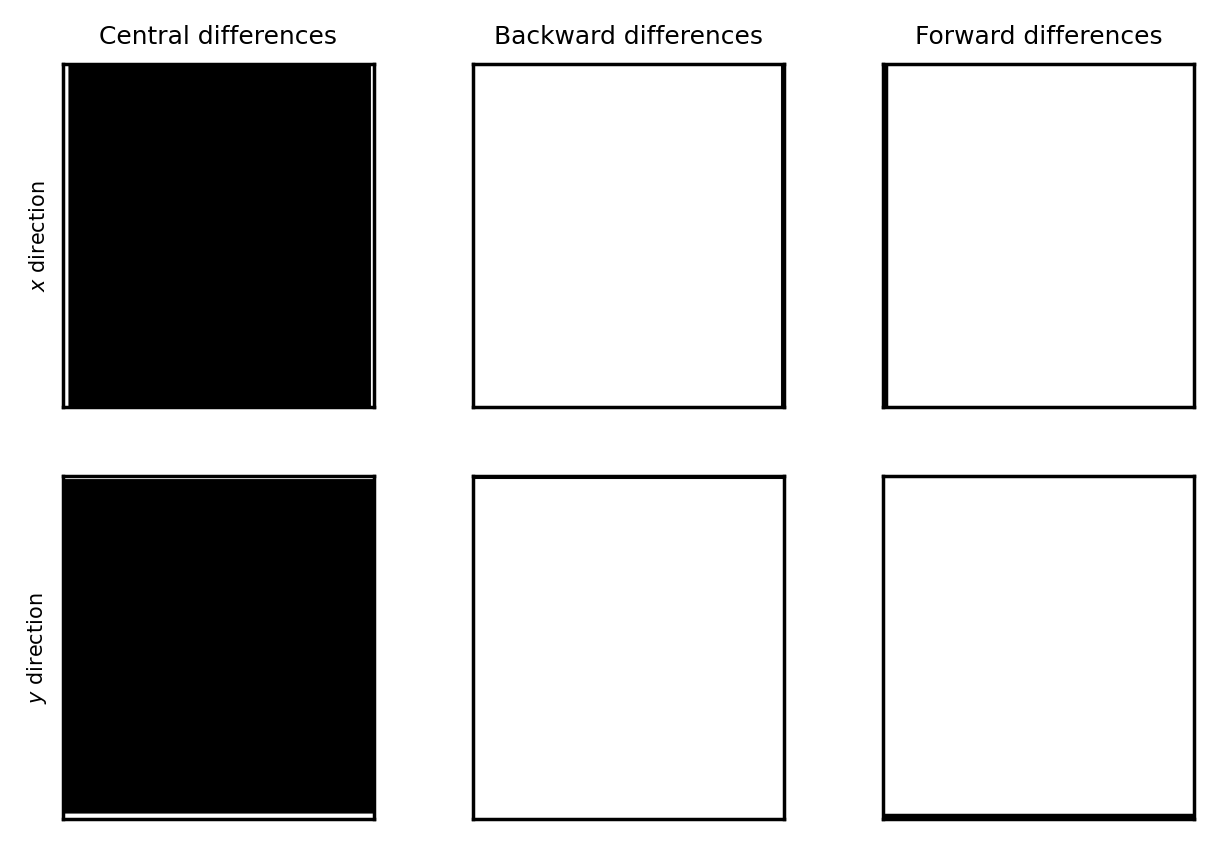

In [20]:
from finite_differences import build_masks

#Build filters for central, forward, and backward differences (copied from wikipedia)
mw = 3 #Mask width
central_1 = np.array([-1/60, 3/20, -3/4, 0, 3/4, -3/20, 1/60])
forward_1 = np.array([-11/6, 3, -3/2, 1/3])
backward_1 = np.array([-1/3, 3/2, -3, 11/6])

central_2 = np.array([1/90, -3/20, 3/2, -49/18, 3/2, -3/20, 1/90])
forward_2 = np.array([2, -5, 4, -1])
backward_2 = np.array([-1, 4, -5, 2])

fd_1 = (central_1, forward_1, backward_1)
fd_2 = (central_2, forward_2, backward_2)

masks = build_masks(mask, mw)
mask, central_y, central_x, forward_y, forward_x, backward_y, backward_x = masks

fig, ax = plt.subplots(2, 3)

plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'Greys'

ax[0, 0].imshow(central_x)
ax[1, 0].imshow(central_y)

ax[0, 1].imshow(backward_x)
ax[1, 1].imshow(backward_y)

ax[0, 2].imshow(forward_x)
ax[1, 2].imshow(forward_y)

ax[0, 0].set(ylabel='$x$ direction', title='Central differences')
ax[0, 1].set(title='Backward differences')
ax[0, 2].set(title='Forward differences')

ax[1, 0].set(ylabel='$y$ direction')

for a in ax.flatten():
    a.set(xticks=[], yticks=[])

## Sociohydrodynamics PINN


$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j  - \Gamma_i \phi_i \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

[[0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0. ]]
[0. 0.]
t = 1980	9.75e-05 s
Dij = 1.000e-01, grad = 2.151e-01, grad^3 = 4.737e+00
(1 - P) = 8.329e-01, P_i = 9.083e-01
Diffusion term = 2.151e-02, Gamma term = 0.000e+00, div(J) = 3.461e-02

t = 1990	42.2 s
Dij = 1.000e-01, grad = 3.999e+53, grad^3 = 3.384e+55
(1 - P) = 1.327e+54, P_i = 1.374e+54
Diffusion term = 3.999e+52, Gamma term = 0.000e+00, div(J) = 1.954e+55



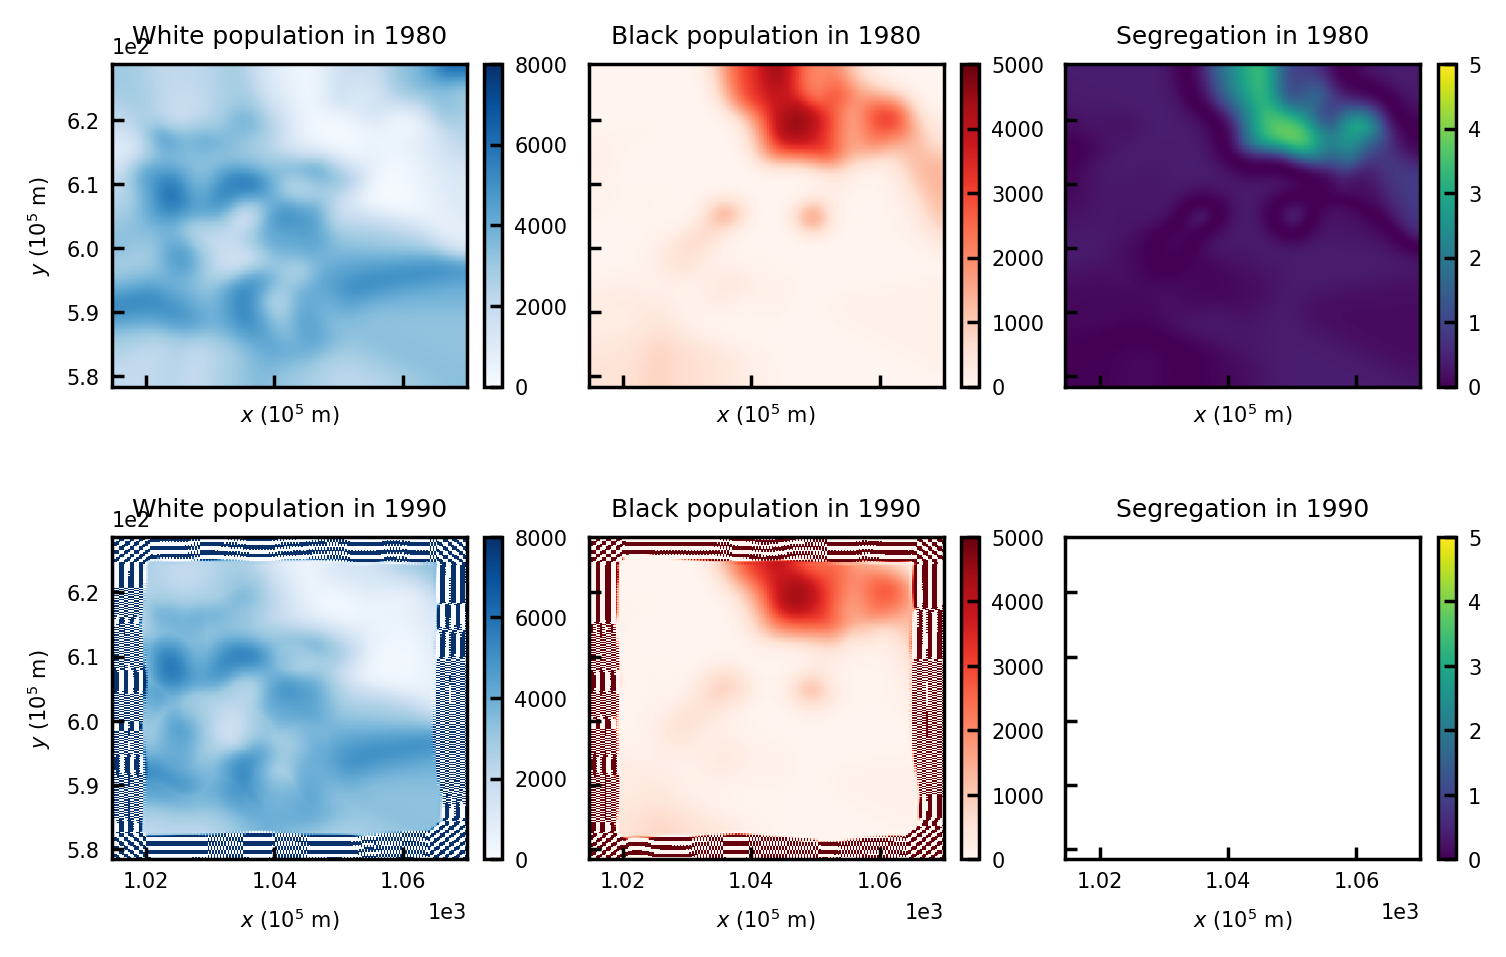

In [21]:
from time import time
from finite_differences import *

dx = x_grid[1, 1] - x_grid[0, 0]
dy = y_grid[1, 1] - y_grid[0, 0]
dd = (dx + dy) / 2

Dij = np.zeros([4, *x_grid.shape])
grad1_wb = np.zeros([2, *x_grid.shape, 2])
grad3_wb = np.zeros([2, *x_grid.shape, 2])
div_J = np.zeros([*x_grid.shape, 2])

def dt_Pwb(wb, log=False):
    '''
    wb is shape [Y, X, 2]
    cij is shape [4,6]
    gammas is shape [2,]
    '''
    calculate_Dij(wb, cij, Dij, mask)
    calculate_grad1(wb, grad1_wb, dd, fd_1, masks)
    calculate_grad3(wb, grad3_wb, dd, fd_1, fd_2, masks)
    Dij[:, mask] = 0
    grad1_wb[:, mask] = 0
    grad3_wb[:, mask] = 0
    if log:
        print(f'Dij = {np.max(Dij):.3e}, grad = {np.max(grad1_wb):.3e}, grad^3 = {np.max(grad3_wb):.3e}')
    
    #Compute diffusive term    
    Dwb = np.einsum('ijyx,kyxj->kyxi', 
                    Dij.reshape([2, 2, *x_grid.shape]), #[2,2,Y,X] Dij[0] -> w, Dij[1] -> b
                    grad1_wb) #[2,Y,X,2]
        
    #Compute gamma term
    pref = 1 - np.sum(wb, axis=2, keepdims=True) #[Y,X,1]
    Gwb = pref * wb * grad3_wb #[2,Y,X,2]
    
    pref[mask] = 0
    Gwb[:, mask] = 0
    if log:
        print(f'(1 - P) = {np.max(np.abs(pref)):.3e}, P_i = {np.max(np.abs(wb)):.3e}')
    Gwb *= gammas[:, None, None, None] #[2,Y,X,2]
    
    #Combine and take the divergence
    calculate_div(Dwb,# - Gwb, 
                  div_J, 
                  dd, fd_1, masks)
    div_J[mask] = 0
    
    if log:
        print(f'Diffusion term = {np.max(Dwb):.3e}, Gamma term = {np.max(Gwb):.3e}, div(J) = {np.max(div_J):.3e}\n')
    
    return div_J

gammas = np.zeros([2,])
cij = np.zeros([4,6])
cij[0, 0] = .1
cij[3, 0] = .1

print(cij)
print(gammas)


t = T[0]
dt = .1
t_log = int(np.round((T[1] - T[0]) / dt))
ii, jj = 0, 0

wb = np.stack([w_grid[0], b_grid[0]], axis=-1)
wb[mask] = 0
wb_grid = []

tt = time()
while t <= T[1]:
    if ii % t_log == 0:
        wb_grid.append(wb)
        print(f't = {t:g}\t{time()-tt:.3g} s')
        dt_Pwb(wb, log=True)
        jj += 1
        tt = time()
    wb = rk4(wb, dt, dt_Pwb)
    if np.any(np.isnan(wb)):
        print(f'Aborting at t = {t:g}')
        break
    ii += 1
    t += dt
    
wb_grid = np.stack(wb_grid)

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)
ii = 1
plot_white_black_seg(fig, ax[0], wb_grid[0,...,0], wb_grid[0,...,1], T[0], **kwargs)
plot_white_black_seg(fig, ax[1], wb_grid[ii,...,0], wb_grid[ii,...,1], T[ii], **kwargs)

plt.tight_layout()

## Testing a simpler case

It appears like there are issues related to edge effects. To test the simpler case, let's test explicit computation of a laplacian against div(grad) -- they should be similar

div(grad) = 6.968e+00, lapl = 2.077e+00
i = 0	1.51 s
div(grad) = 2.781e+02, lapl = 1.073e+02
i = 1	0.00842 s
div(grad) = 8.880e+03, lapl = 4.072e+03
i = 2	0.00832 s
div(grad) = 2.405e+05, lapl = 1.188e+05
i = 3	0.00832 s
div(grad) = 5.891e+06, lapl = 3.036e+06
i = 4	0.00832 s
div(grad) = 1.352e+08, lapl = 7.160e+07
i = 5	0.00837 s
div(grad) = 2.961e+09, lapl = 1.597e+09
i = 6	0.0104 s
div(grad) = 6.268e+10, lapl = 3.988e+10
i = 7	0.0114 s
div(grad) = 1.286e+12, lapl = 1.597e+12
i = 8	0.00931 s
div(grad) = 4.836e+13, lapl = 6.768e+13
i = 9	0.00832 s
div(grad) = 2.011e+15, lapl = 2.746e+15
i = 10	0.00847 s
div(grad) = 7.953e+16, lapl = 1.175e+17
i = 11	0.00831 s
div(grad) = 3.335e+18, lapl = 4.815e+18
i = 12	0.00832 s
div(grad) = 1.352e+20, lapl = 2.152e+20
i = 13	0.00831 s
div(grad) = 5.723e+21, lapl = 9.204e+21
i = 14	0.0083 s
div(grad) = 2.359e+23, lapl = 4.149e+23
i = 15	0.00831 s
div(grad) = 1.008e+25, lapl = 1.790e+25
i = 16	0.00833 s
div(grad) = 4.204e+26, lapl = 8.079e+26
i = 17	

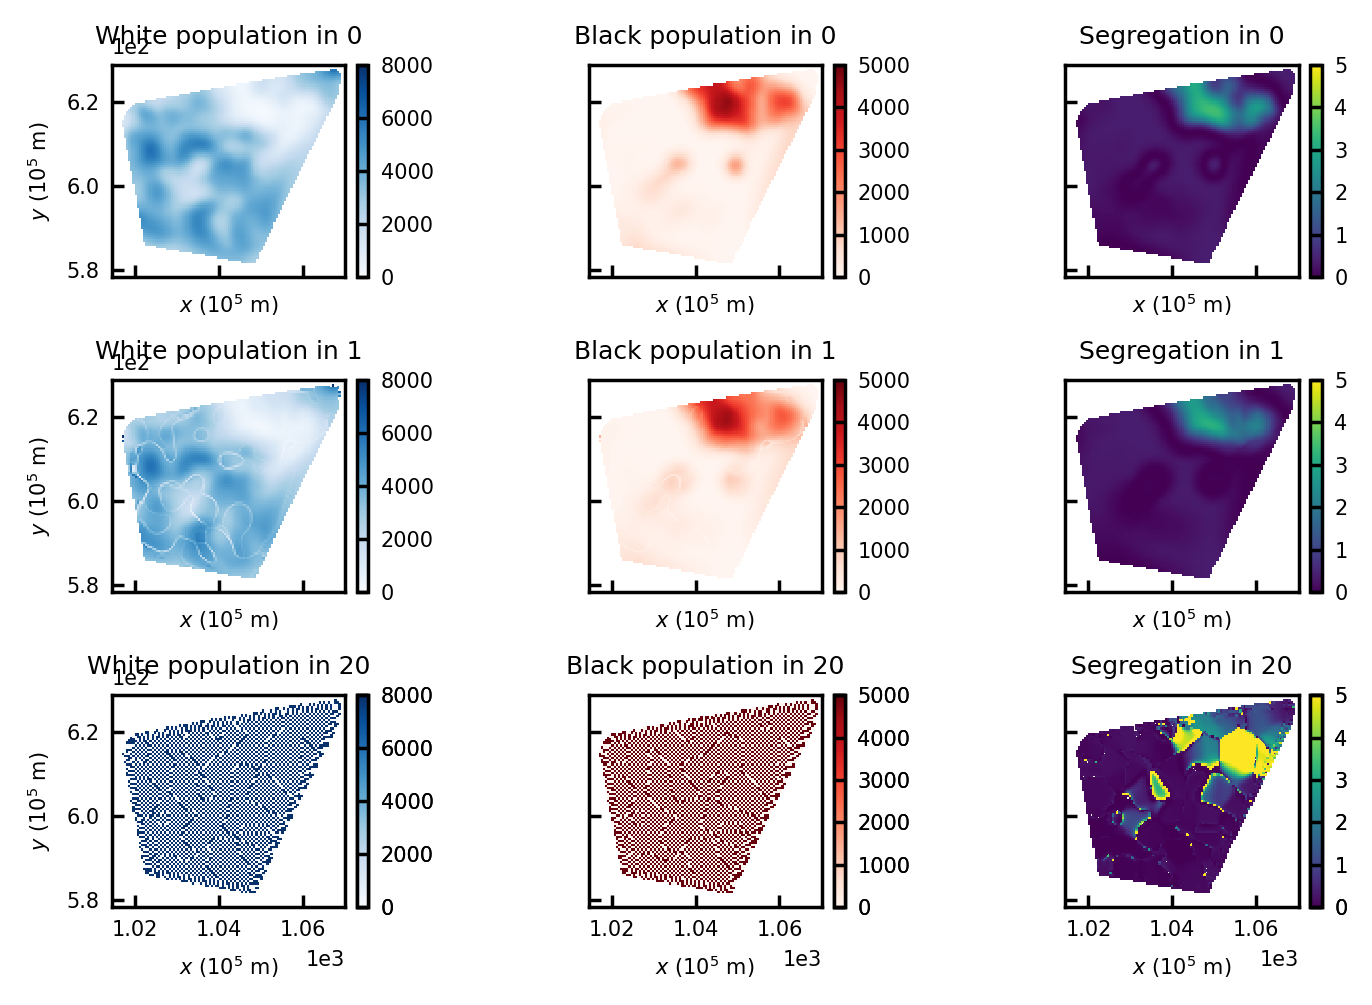

In [5]:
from time import time
from finite_differences import *

dx = x_grid[1, 1] - x_grid[0, 0]
dy = y_grid[1, 1] - y_grid[0, 0]
dd = (dx + dy) / 2

Dij = np.zeros([4, *x_grid.shape])
grad1_wb = np.zeros([2, *x_grid.shape, 2])
div_J = np.zeros([*x_grid.shape, 2])
lapl_wb = np.zeros([*x_grid.shape, 2])

def iterate_Pwb(wb, log=True):
    '''
    wb is shape [Y, X, 2]
    cij is shape [4,6]
    gammas is shape [2,]
    '''
    calculate_grad1(wb, grad1_wb, dd, fd_1, masks)
    calculate_div(grad1_wb, div_J, dd, fd_1, masks)
    
    calculate_lapl(wb, lapl_wb, dd, fd_2, masks)
    div_J[mask] = 0
    lapl_wb[mask] = 0
    if log:
        print(f'div(grad) = {np.max(div_J):.3e}, lapl = {np.max(lapl_wb):.3e}')
        
    return lapl_wb

n_iter = 20
t = T[0]
ii = 0

wb = np.stack([w_grid[0], b_grid[0]], axis=-1)
wb[mask] = 0
wb_grid = np.zeros([n_iter+1, *wb.shape])

tt = time()
while ii < n_iter:
    tt = time()
    wb_grid[ii] = wb
    wb += iterate_Pwb(wb, log=True)
    print(f'i = {ii:g}\t{time()-tt:.3g} s')
    ii += 1
wb_grid[ii] = wb

fig, ax = plt.subplots(3, 3, sharey=True, sharex=True)
for i in range(3): 
    plot_white_black_seg(fig, ax[i], wb_grid[i,...,0], wb_grid[i,...,1], i, **kwargs)
plot_white_black_seg(fig, ax[-1], wb_grid[-1,...,0], wb_grid[-1,...,1], ii, **kwargs)

plt.tight_layout()

# Integrating PINNs

## Linear PINN


$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j  - \Gamma_i \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} $$

[[-0.03  0.    0.    0.    0.    0.  ]
 [-0.01  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]
 [ 0.07  0.    0.    0.    0.    0.  ]]
[ 0.03 -0.06]
t = 1980	0.000107 s
Dij = 7.012e-02, grad = 1.184e+00, grad^3 = 1.885e+01
(1 - P) = 7.028e-01, P_i = 9.081e-01
Diffusion term = 5.901e-02, Gamma term = 7.221e-02, div(J) = 3.234e-01

t = 1990	0.39 s
Dij = 7.012e-02, grad = 4.864e+03, grad^3 = 3.757e+04
(1 - P) = 1.075e+04, P_i = 1.178e+04
Diffusion term = 3.404e+02, Gamma term = 8.952e+11, div(J) = 1.163e+04



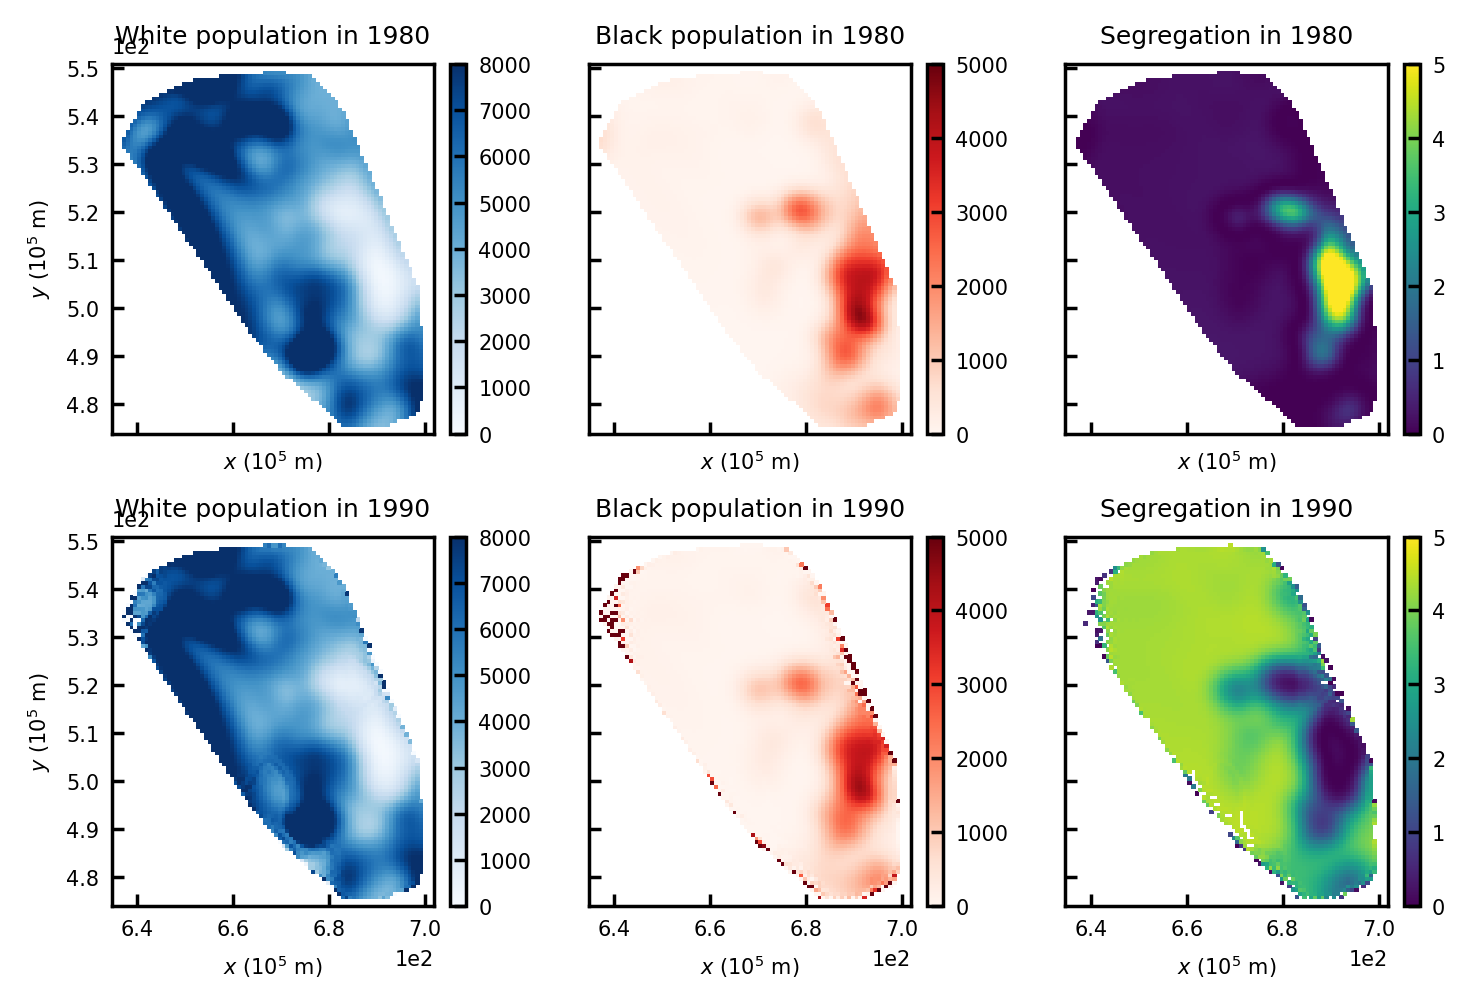

In [9]:
from time import time
from finite_differences import *
from pinn import *

info = torch.load(f'data/LinearDiffusionLinearPINN', map_location='cpu')
cij = info['state_dict']['coefs'].detach().numpy()
gammas = info['state_dict']['gammas'].detach().numpy()

print(cij)
print(gammas)


t = T[0]
dt = 1
t_log = int(np.round((T[1] - T[0]) / dt))
ii, jj = 0, 0

wb = np.stack([w_grid[0], b_grid[0]], axis=-1)
wb[mask] = 0
wb_grid = []

tt = time()
while t <= T[1]:
    if ii % t_log == 0:
        wb_grid.append(wb)
        print(f't = {t:g}\t{time()-tt:.3g} s')
        dt_Pwb(wb, log=True)
        jj += 1
        tt = time()
    wb = rk4(wb, dt, dt_Pwb)
    if np.any(np.isnan(wb)):
        print(f'Aborting at t = {t:g} -- NaNs found')
        break
    ii += 1
    t += dt
    
wb_grid = np.stack(wb_grid)

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)
ii = 1
plot_white_black_seg(fig, ax[0], wb_grid[0,...,0], wb_grid[0,...,1], T[0], **kwargs)
plot_white_black_seg(fig, ax[1], wb_grid[ii,...,0], wb_grid[ii,...,1], T[ii], **kwargs)

plt.tight_layout()

## Sociohydrodynamics PINN


$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j  - \Gamma_i \phi_i \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

[[ 0.18 -0.46 -0.8   0.29  0.75  0.71]
 [ 0.01 -0.19 -0.29  0.33  0.37  0.19]
 [ 0.02 -0.1   0.03  0.08 -0.14  0.11]
 [ 0.    0.02  0.36 -0.08 -0.42 -0.3 ]]
[ 0.14 -0.21]
t = 1980	0.000104 s
Dij = 1.105e-01, grad = 1.184e+00, grad^3 = 1.885e+01
(1 - P) = 7.028e-01, P_i = 9.081e-01
Diffusion term = 1.021e-02, Gamma term = 4.076e-01, div(J) = 5.433e-02

Aborting at t = 1986 -- NaNs found


IndexError: index 1 is out of bounds for axis 0 with size 1

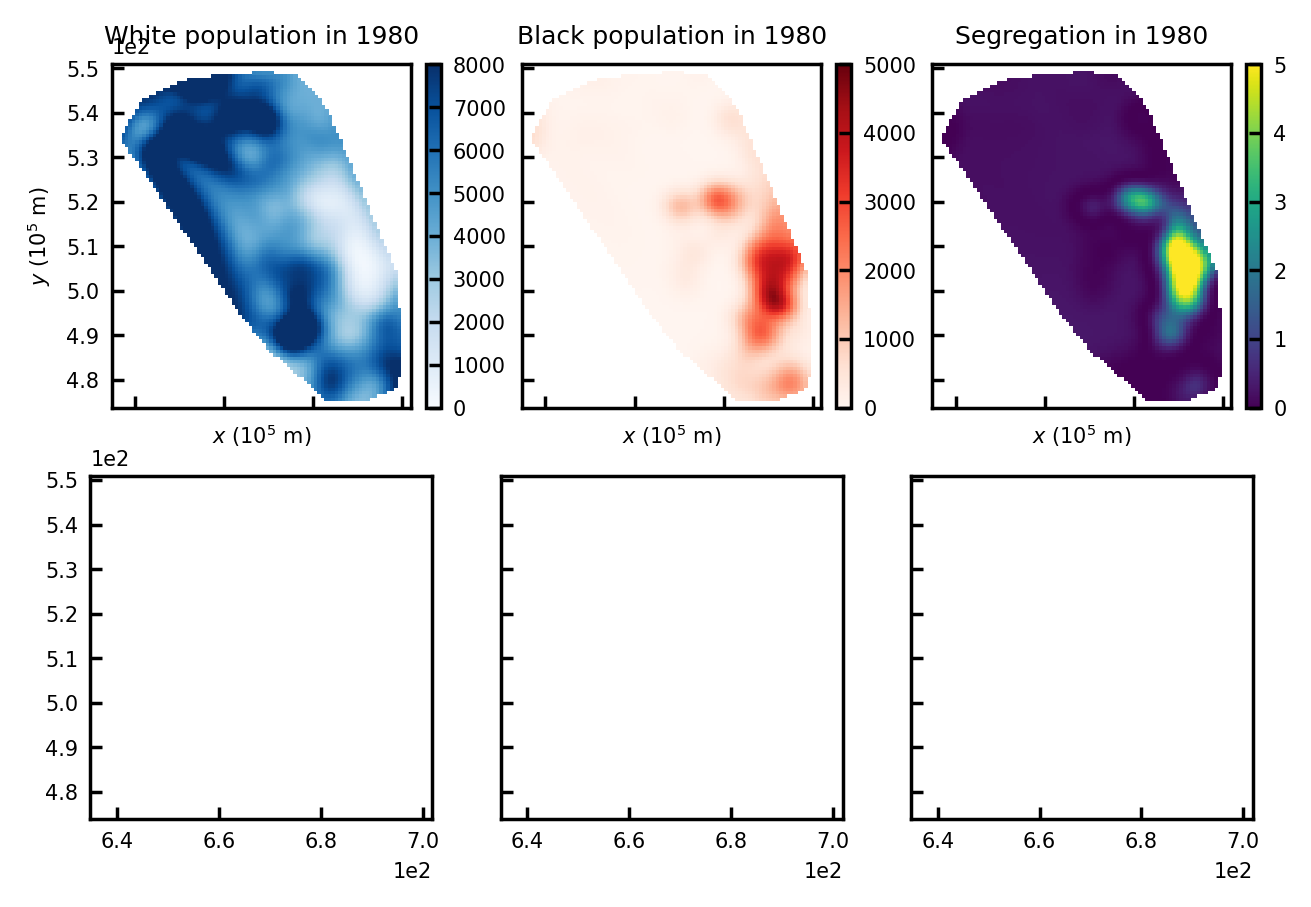

In [7]:
from time import time
from finite_differences import *

info = torch.load(f'data/SociohydrodynamicsPINN', map_location='cpu')
cij = info['state_dict']['coefs'].detach().numpy()
gammas = info['state_dict']['gammas'].detach().numpy()

print(cij)
print(gammas)


t = T[0]
dt = 1
t_log = int(np.round((T[1] - T[0]) / dt))
ii, jj = 0, 0

wb = np.stack([w_grid[0], b_grid[0]], axis=-1)
wb[mask] = 0
wb_grid = []

tt = time()
while t <= T[1]:
    if ii % t_log == 0:
        wb_grid.append(wb)
        print(f't = {t:g}\t{time()-tt:.3g} s')
        dt_Pwb(wb, log=True)
        jj += 1
        tt = time()
    wb = rk4(wb, dt, dt_Pwb)
    if np.any(np.isnan(wb)):
        print(f'Aborting at t = {t:g} -- NaNs found')
        break
    ii += 1
    t += dt
    
wb_grid = np.stack(wb_grid)

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)
ii = 1
plot_white_black_seg(fig, ax[0], wb_grid[0,...,0], wb_grid[0,...,1], T[0], **kwargs)
plot_white_black_seg(fig, ax[1], wb_grid[ii,...,0], wb_grid[ii,...,1], T[ii], **kwargs)

plt.tight_layout()